### Overview

I'm going to investigate normalisation's effect on the model's performance.

Remember how I got a very differing set of MSEs for $y_{0}$ and $y_{1}$ predictions in multidimensionality? I'm going to see if I can resolve that here.

See, when I computed the MSEs for my outputs, since *they* differed in scale, so did the scale of their MSEs. Normalisation should prevent this from happening, since they'll both share a common scale, meaning their MSEs should be more easily interpretable.

I'm going to use the following formula to normalise both $x$ and $y$:

$x_{n}^{'} = \frac{x- \langle x \rangle}{\sigma \langle x \rangle}$, $y_{n}^{'} = \frac{y- \langle y \rangle}{\sigma \langle y \rangle}$.

I'm also going to use same the model architecture as multidimensionality's one.

I'm changing how inputs are mapped a little, though:

$x_{0}, x_{1} \rightarrow y_{0}; \; x_{0}, x_{1} \rightarrow y_{1}.$ Let $x = (x_{0}, x_{1})$.

$f_{0}(x) = y_{0} = 4x_{0}^{5} + 12x_{1}^{3} - 5$.

$f_{1}(x) = y_{1} = 3x_{0}^{4} - 7x_{1}^{2} + 9x_{0}x_{1}$.

With that, I'll:
* Import my libraries
* Declare my model's architecture
* Normalise my dataset
* Train my model
* Test my model 

### Libraries

In [65]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### The Model

In [66]:
class DualOutputBNN(nn.Module):
    def __init__(self, no_of_neurones, dropout_prob):
        super(DualOutputBNN, self).__init__()
        self.shared_layer = nn.Sequential( #this is the input layer
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        self.output_layer_y0 = nn.Sequential( #this is the output layer for y0
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )
        self.output_layer_y1 = nn.Sequential( #this is the output layer for y1
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )


    def forward(self, x): #this is the forward pass, run automatically when you call the model
        shared = self.shared_layer(x)
        y0 = self.output_layer_y0(shared)
        y1 = self.output_layer_y1(shared)
        return y0, y1

### Initialising the Model

In [67]:
def initialise_model(no_of_neurones: int, dropout_prob: float, lr: float = 0.01) -> tuple:
    """
    Initialise the DualOutputBNN model with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - dropout_prob (float): Dropout probability.
    - lr (float): Learning rate for the optimizer. Default is 0.01.

    Returns:
    - A tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    """

    model = DualOutputBNN(no_of_neurones, dropout_prob).to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, mse_loss, kl_loss, kl_weight, optimizer

### Training the model

In [68]:
def train_model(model_attributes, x_train, y_train, epochs: int):
    """
    Train a Bayesian Neural Network model for a specified number of epochs.

    Parameters:
    - model_attributes: A tuple containing the model, loss functions, kl_weight, and optimizer.
    - x_train (torch.Tensor): Input tensor for the training data.
    - y_train (torch.Tensor): Target tensor for the training data.
    - epochs (int): Number of epochs to train the model.

    Returns:
    - model (torch.nn.Sequential): The trained neural network model.

    Ensures that training data and model are on the same device for efficiency.
    """

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes

    model.train()
    for _ in range(epochs): 
        y0_pred, y1_pred = model(x_train)
        y0_mse, y1_mse = mse_loss(y0_pred, torch.unsqueeze(torch.Tensor(y_train[:,0]), dim=1)), mse_loss(y1_pred, torch.unsqueeze(torch.Tensor(y_train[:,1]), dim=1))
        kl = kl_loss(model)
        y0_cost, y1_cost = y0_mse + kl_weight * kl, y1_mse + kl_weight * kl
        cost = y0_cost + y1_cost

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    # print(f"- Cost: {cost.item():.3f}")

    return model

### Testing the Model

In [69]:
def test_model(model, x_test):
    """
    Test a Bayesian Neural Network model to produce predictions along with mean and standard deviation.

    Parameters:
    - model (torch.nn.Sequential): The trained neural network model.
    - func (callable): The target function to compare against the model's predictions.

    Returns:
    - mean_model_results (numpy.ndarray): Array of mean predictions from the model.
    - std_model_results (numpy.ndarray): Array of standard deviations of the predictions.
    - x_test (torch.Tensor): Testing dataset inputs.
    - y_test (torch.Tensor): Testing dataset targets.

    The testing data is moved to the device specified by the global `device` variable.
    """

    #producing predictions of model of testing data, as well as mean and standard deviation of predictions
    model.eval().cpu()
    y0_pred, y1_pred = model(x_test)[0], model(x_test)[1]

    y0_pred, y1_pred = np.array([model(x_test)[0].detach().numpy() for _ in range(500)])[:,:,0].T, np.array([model(x_test)[1].detach().numpy() for _ in range(500)])[:,:,0].T

    mean_y0_results, std_y0_results = np.array([np.mean(y0_pred[i]) for i in range(y0_pred.shape[0])]), np.array([np.std(y0_pred[i]) for i in range(y0_pred.shape[0])])
    mean_y1_results, std_y1_results = np.array([np.mean(y1_pred[i]) for i in range(y1_pred.shape[0])]), np.array([np.std(y1_pred[i]) for i in range(y1_pred.shape[0])])

    return mean_y0_results, std_y0_results, mean_y1_results, std_y1_results 

### Processing the Dataset

In [70]:
def generate_dataset(df: pd.DataFrame, func0, func1):
    #splitting data into training and testing sets
    x_train, x_test = train_test_split(df[["x0", "x1"]], test_size=0.2, random_state=1)

    #reset indices and drop old indices of train and test sets
    x_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)

    #train_test_split causes data unordering. I fix that with the lines below
    x_train = x_train.apply(lambda x: x.sort_values().values)
    x_test = x_test.apply(lambda x: x.sort_values().values)
    
    #generating y values
    y_train, y_test = pd.DataFrame(), pd.DataFrame()
    y_train["y0"], y_train["y1"] = func0(torch.Tensor(x_train["x0"]), torch.Tensor(x_train["x1"])), func1(torch.Tensor(x_train["x0"]), torch.Tensor(x_train["x1"]))
    y_test["y0"], y_test["y1"] = func0(torch.Tensor(x_test["x0"]), torch.Tensor(x_test["x1"])), func1(torch.Tensor(x_test["x0"]), torch.Tensor(x_test["x1"]))


    #normalising dataset
    normalise = lambda x: (x - np.mean(x)) / (np.std(x))
    x_train["x0"], x_train["x1"] = normalise(x_train["x0"]), normalise(x_train["x1"])
    x_test["x0"], x_test["x1"] = normalise(x_test["x0"]), normalise(x_test["x1"])
    print(type(x_train), type(x_test))

    # print(x_train["x0"], x_train["x1"])

    y_train["y0"], y_train["y1"] = normalise(y_train["y0"]), normalise(y_train["y1"])
    y_test["y0"], y_test["y1"] = normalise(y_test["y0"]), normalise(y_test["y1"])
    print(len(y_train), len(y_test))

    return x_train, x_test, y_train, y_test

### Creating the Dataset

Of course, eventually, when I'm working with real data, this'll be more like "*Processing* the Dataset", but we're seeing what'll happen theoretically, so creating data is fine here.

In [71]:
x0, x1 = torch.rand(2000)*6 - 3, torch.rand(2000)*6 - 3

#declaring target functions and their outputs
clean_f0 = lambda x0, x1: 4*np.power(x0, 5) + 12*np.power(x1, 3) - 5
clean_f1 = lambda x0, x1: 3*np.power(x0, 4) - 7*np.power(x1, 2) + 9*x0*x1
# clean_f0 = lambda x0, x1: x1 + x0
# clean_f1 = lambda x0, x1: x1 - x0

clean_y0, clean_y1 = clean_f0(x0, x1), clean_f1(x0, x1)

#declaring noisy functions and their outputs
max_y0_scale, max_y1_scale = clean_y0.max()*0.2, clean_y1.max()*0.2 #scale for noisy function
f0 = lambda x0, x1: clean_f0(x0, x1) + (max_y0_scale*torch.rand(x0.size()) - max_y0_scale/2)
f1 = lambda x0, x1: clean_f1(x0, x1) + (max_y1_scale*torch.rand(x0.size()) - max_y1_scale/2)

#processing dataset
df = pd.DataFrame({'x0': x0, 'x1': x1})
#save this df to csv
df.to_csv("../../data/normalisation/initial_data.csv")

x_train, x_test, y_train, y_test = generate_dataset(df, f0, f1)
y_test

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
1600 400


,y0,y1
0,-2.593161,2.799679
1,-2.971817,2.553756
2,-2.801836,2.687606
3,-2.836124,2.230726
4,-2.697807,2.581933
...,...,...
395,2.861216,2.048167
396,2.783566,2.586884
397,2.618675,2.155982
398,2.970936,2.416977


In [72]:
#converting data to tensors for the model to use
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)
x_train, x_test, y_train, y_test = torch.Tensor(x_train).to(device), torch.Tensor(x_test), torch.Tensor(y_train).to(device), torch.Tensor(y_test)

#where the machine learning occurs...
model_attributes = initialise_model(1000, 0.3)
model = train_model(model_attributes, x_train, y_train, 1000)
mean_y0_results, std_y0_results, mean_y1_results, std_y1_results = test_model(model, x_test)

mse_loss = nn.MSELoss().to(device)
mean_y0_mse, mean_y1_mse = mse_loss(torch.Tensor(mean_y0_results), y_test[:,0]), mse_loss(torch.Tensor(mean_y1_results), y_test[:,1])

print(f"mean_y0_mse: {mean_y0_mse}, mean_y1_mse: {mean_y1_mse}")
print(f"mean std(y0): {np.mean(std_y0_results)}, mean std(y1): {np.mean(std_y1_results)}")

mean_y0_mse: 0.13293348252773285, mean_y1_mse: 0.08714643120765686
mean std(y0): 0.19013568758964539, mean std(y1): 0.2252960205078125


In [73]:
#form a csv of the above
df = pd.DataFrame({'x0': x_test[:,0], 'x1': x_test[:,1], 'y0': y_test[:,0], 'y1': y_test[:,1], 'mean_y0': mean_y0_results, 'mean_y1': mean_y1_results, 'std_y0': std_y0_results, 'std_y1': std_y1_results})

df.to_csv("../../data/normalisation/normalised_results.csv")

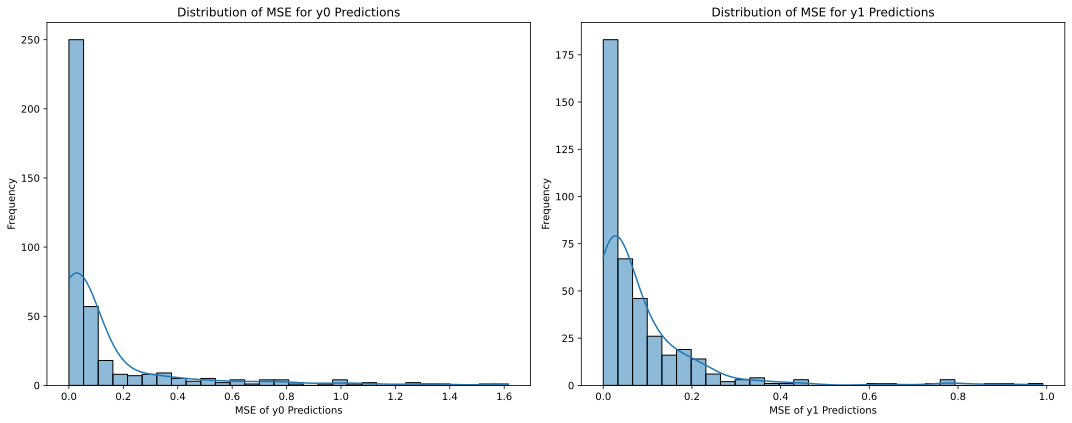

In [74]:
# Assuming normalized_data is your DataFrame
normalized_data = pd.read_csv('../../data/normalisation/normalised_results.csv')

# Calculating the Mean Squared Errors (MSE) for each data point for y0 and y1 predictions
normalized_data['mse_y0'] = (normalized_data['y0'] - normalized_data['mean_y0']) ** 2
normalized_data['mse_y1'] = (normalized_data['y1'] - normalized_data['mean_y1']) ** 2

# Plotting the MSEs for y0 and y1
plt.figure(figsize=(15, 6))

# Plot for MSEs of y0 predictions
plt.subplot(1, 2, 1)
sns.histplot(normalized_data['mse_y0'], bins=30, kde=True)
plt.title('Distribution of MSE for y0 Predictions')
plt.xlabel('MSE of y0 Predictions')
plt.ylabel('Frequency')

# Plot for MSEs of y1 predictions
plt.subplot(1, 2, 2)
sns.histplot(normalized_data['mse_y1'], bins=30, kde=True)
plt.title('Distribution of MSE for y1 Predictions')
plt.xlabel('MSE of y1 Predictions')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

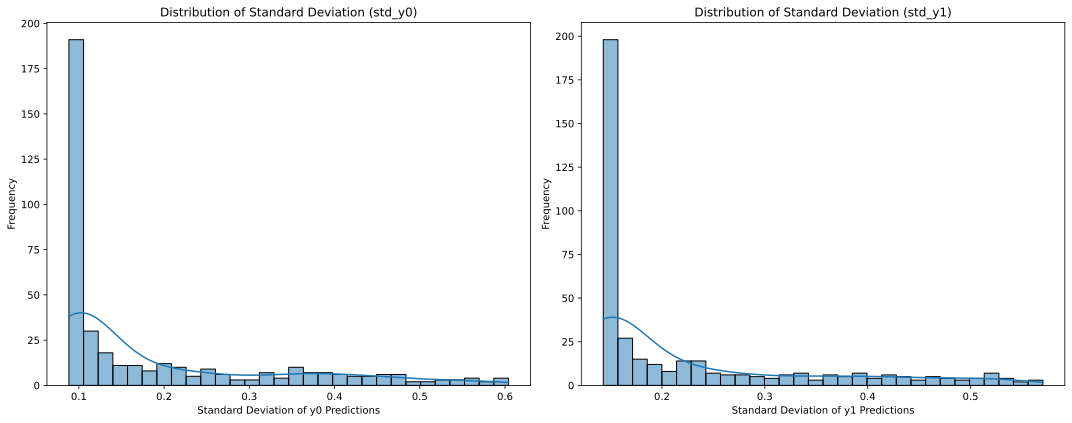

In [75]:
# Plotting the distribution of standard deviations for y0 and y1
plt.figure(figsize=(15, 6))

# Distribution plot for std_y0
plt.subplot(1, 2, 1)
sns.histplot(normalized_data['std_y0'], bins=30, kde=True)
plt.title('Distribution of Standard Deviation (std_y0)')
plt.xlabel('Standard Deviation of y0 Predictions')
plt.ylabel('Frequency')

# Distribution plot for std_y1
plt.subplot(1, 2, 2)
sns.histplot(normalized_data['std_y1'], bins=30, kde=True)
plt.title('Distribution of Standard Deviation (std_y1)')
plt.xlabel('Standard Deviation of y1 Predictions')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()